# Flamingo Project

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

import requests
import numpy as np
import os
import datetime

%matplotlib inline

## Housing Market (US) - Data Analysis

In [3]:
# Data Source: https://www.zillow.com/research/data/

In [20]:
# GLOBAL configuration variables
# Modify to gather data & analyze according to your needs

# Cities to filter data for
# Change this list to gather data for the cities you want to compare.
# E.g. cities_filter = ['miami,fl','seattle,wa','orlando,fl']
cities_filter = ['new york,ny','weehawken,nj']

# Geographies (levels) to use to gather and analyze data
# Eg. State, City, Zipcode, Neighborhood
geographies_filter = ['Zip','Neighborhood']

# Zip codes to filter the data
# Use this filter to limit results to a list of zip ypu want to analyze
zip_filter = ['10011','10012','10001','10023','07087']

# ---------------------------------------------------------------------
# GLOBALS
# Do not modify
path_datasets = 'datasets'
path_indicators = 'indicators'
zillow_endpoint = 'http://files.zillowstatic.com/research/public/'

ccities = []
cstates = []
for city in cities_filter:
    city_name, state = city.split(',')
    ccities.append(city_name)
    cstates.append(state)

## Gathering Data from Zillow

In [42]:
# price_files
# list contains all the target price files from Zillow we want to download and analyze
# Zillow endpoints examples:
#     http://files.zillowstatic.com/research/public/{Zip}/{Zip}_PctOfListingsWithPriceReductions_AllHomes.csv

price_files = [
    '{geography}_MedianRentalPrice_1Bedroom.csv',
    '{geography}_MedianRentalPricePerSqft_1Bedroom.csv',
    
    '{geography}_MedianListingPrice_AllHomes.csv',
    '{geography}_MedianListingPricePerSqft_AllHomes.csv',

    '{geography}_MedianRentalPrice_2Bedroom.csv',
    '{geography}_MedianRentalPricePerSqft_2Bedroom.csv',
    
    '{geography}_MedianRentalPrice_Sfr.csv',
    '{geography}_MedianRentalPricePerSqft_Sfr.csv',
    
    '{geography}_PriceToRentRatio_AllHomes.csv',
    
    '{geography}_Zhvi_SingleFamilyResidence.csv',
    '{geography}_Zhvi_1bedroom.csv',
    '{geography}_Zhvi_2bedroom.csv',

    '{geography}_PctOfListingsWithPriceReductions_AllHomes.csv',
    '{geography}_MedianPctOfPriceReduction_AllHomes.csv',
    '{geography}_PctOfHomesIncreasingInValues_AllHomes.csv',
    '{geography}_PctOfHomesDecreasingInValues_AllHomes.csv',
    
    'Zip/BuyerSellerIndex_Zip.csv',
    'Zip/MarketHealthIndex_Zip.csv',
    'City/MonthlyTurnover_City.csv'
]
output_price_files = [
    '{city}/{geography}_rent_1BR_total.csv',
    '{city}/{geography}_rent_1BR_sqft.csv',

    '{city}/{geography}_buy_home.csv',
    '{city}/{geography}_buy_home_sqft.csv',
    
    '{city}/{geography}_rent_2BR_total.csv',
    '{city}/{geography}_rent_2BR_sqft.csv',
    
    '{city}/{geography}_rent_SF_total.csv',
    '{city}/{geography}_rent_SF_sqft.csv',
    
    '{city}/{geography}_price_rent_ratio.csv',
    
    '{city}/{geography}_price_series_SF.csv',
    '{city}/{geography}_price_series_1BR.csv',
    '{city}/{geography}_price_series_2BR.csv',
    
    '{city}/{geography}_pct_price_reduction_homes.csv',
    '{city}/{geography}_median_pct_price_reduction_homes.csv',
    '{city}/{geography}_pct_home_increasing_in_values.csv',
    '{city}/{geography}_pct_home_decreasing_in_values.csv',
    
    '{city}/{geography}_buyer_seller_index.csv',
    '{city}/{geography}_market_health_index.csv',
    '{city}/City_monthly_turnover.csv',
]

# price_files
# list contains all the target indicator files from Zillow we want to download and analyze
# Zillow endpoints examples:
#     http://files.zillowstatic.com/research/public/{indicator}.csv

indicator_files = [
#     'Affordability_Income_2018Q2.csv',
#     'Affordability_Wide_2018Q2_Public.csv',
#     'BreakEven_PR_2018-032.csv',
#     'AllRegionsForePublic.csv', # forecast price homes
    'ZriForecast_Public.csv' #forecast rent
]
output_indicator_files = [
    'affordability_income.csv',
    'affordability_wide.csv',
    'breakeven_rate.csv',
    'home_forecast.csv',
    'rent_forecast.csv'
]

In [40]:
# get_datasets
# retrieves the csv files from Zillow using the price_files and indicator_files list

def get_datasets(save_path, geographies, files):
    def requestUrl(url, save_path):
        try:
            r = requests.get(url, allow_redirects=True)
            if r.status_code == 200:
                open(save_path, 'wb').write(r.content)
                print('File downloaded: ' + url + ' - ' + str(r.status_code))
            else:
                print('File not downloaded: ' + url + ' - ' + str(r.status_code))
        except requests.exceptions.RequestException as err:
            print('Error ocurred while processing file: ' + url, err)
    
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    if geographies:
        for geography in geographies:
            for file in files:
                f = file.replace('{geography}', geography)
                if f == file:
                    url = zillow_endpoint + f
                    f = f.replace('/','_')
                else:
                    url = zillow_endpoint + geography + '/' + f
                requestUrl(url, save_path + '/' + f)
    else:
        for file in files:
            url = zillow_endpoint + file
            requestUrl(url, save_path + '/' + file)
    print('Datasets retrieved successfully and saved at ' + save_path)

In [23]:
get_datasets(path_datasets, geographies_filter, price_files)

File downloaded: http://files.zillowstatic.com/research/public/Zip/Zip_MedianRentalPrice_1Bedroom.csv - 200
File downloaded: http://files.zillowstatic.com/research/public/Zip/Zip_MedianRentalPricePerSqft_1Bedroom.csv - 200
File downloaded: http://files.zillowstatic.com/research/public/Zip/Zip_MedianListingPrice_AllHomes.csv - 200
File downloaded: http://files.zillowstatic.com/research/public/Zip/Zip_MedianListingPricePerSqft_AllHomes.csv - 200
File downloaded: http://files.zillowstatic.com/research/public/Zip/Zip_MedianRentalPrice_2Bedroom.csv - 200
File downloaded: http://files.zillowstatic.com/research/public/Zip/Zip_MedianRentalPricePerSqft_2Bedroom.csv - 200
File downloaded: http://files.zillowstatic.com/research/public/Zip/Zip_MedianRentalPrice_Sfr.csv - 200
File downloaded: http://files.zillowstatic.com/research/public/Zip/Zip_MedianRentalPricePerSqft_Sfr.csv - 200
File downloaded: http://files.zillowstatic.com/research/public/Zip/Zip_PriceToRentRatio_AllHomes.csv - 200
File down

In [43]:
get_datasets(path_indicators, [], indicator_files)

File downloaded: http://files.zillowstatic.com/research/public/ZriForecast_Public.csv - 200
Datasets retrieved successfully and saved at indicators


### Dataset processing functions

In [34]:
# process_prices
# _filters datasets from Zillow and outputs them into a separate file
#
# args:
#     - city: city to filter for
#     - state: state to filter for
#     - geography: level to filter data (zip, neighborhood)
#     - inputFile: path to input dataset
#     - inputFile: path to output dataset
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

def process_prices(city, state, geography, inputFile, outputFile):    
    def filterByGeographies(df):
        if 'State' in df.columns:
            df = df[df.State.str.contains(state, case=False, na=False)]
        if 'StateName' in df.columns:
            df = df[df.StateName.str.contains(state, case=False, na=False)]
        if 'City' in df.columns:
            df = df[df.City.str.contains(city, case=False, na=False, regex=True)]
            #df = df[~df.City.str.contains('beach|tamiami|north|south|gardens|springs', case=False, na=False)]
        if 'Metro' in df.columns:
            df = df[df.Metro.str.contains(city, case=False, na=False, regex=True)]
        return df
    
    ifile = inputFile.replace('{geography}', geography)
    if ifile == inputFile:
        ifile = inputFile.replace('/','_')
    ofile = outputFile.replace('{geography}', geography)
    ofile = ofile.replace('{city}', city)
    ifile = path_datasets + '/' + ifile

    if os.path.exists(ifile):
        print(ifile)
        df = pd.read_csv(ifile,  encoding='latin-1')
        if 'RegionName' in df.columns:
            df['RegionName'] = df['RegionName'].astype(str)
            if hasNumbers(df['RegionName'][0]):
                df = df[df.RegionName.str.contains('|'.join(zip_filter), case=False, na=False)]
            else:
                df = filterByGeographies(df)
        if 'Neighborhood' in df.columns:
            print('Neighbor')
            if hasNumbers(df['Neighborhood'][0]):
                df = df.rename(index=str, columns={'Neighborhood':'Zip'})

        df = df.rename(index=str, columns={'RegionName':geography, 'City':'city','State':'state','Metro':'metro','CountyName':'county','County':'county'})
        df.reset_index(drop=True, inplace=True)
        if 'SizeRank' in df.columns:
            df.drop(['SizeRank'], axis=1, inplace=True)
        df.to_csv(ofile, index=False)

In [35]:
# process_indicators
# _filters datasets from Zillow and outputs them into a separate file
#
# args:
#     - cities: cities to filter data for
#     - inputFile: path to input dataset
#     - inputFile: path to output dataset

def process_indicators(cities, inputFile, outputFile):
    df = pd.read_csv(inputFile)
    df = df[df.RegionName.str.contains('|'.join(cities), case=False, na=False)]
    df = df.rename(index=str, columns={'RegionID':'zipcode','RegionName':'city'})
    df.reset_index(drop=True, inplace=True)
    df.to_csv(outputFile, index=False)

In [36]:
def processPriceDatasets(cities, geographies):
    for city in cities:
        city_name,state = city.split(',')
        if not os.path.exists(city_name):
            os.makedirs(city_name)
        # process geographies
        for geography in geographies:
            for i in range(0,len(price_files)):
                process_prices(city_name, state, geography, price_files[i], output_price_files[i])

def processIndicatorsDatasets(cities):
    icities = []
    for city in cities:
        icities.append(city.split(',')[0])
    if not os.path.exists('indicators'):
            os.makedirs('indicators')
    for i in range(0,len(indicator_files)):
        input_file = path_indicators + '/' + indicator_files[i]
        output_file = path_indicators + '/' + output_indicator_files[i]
        process_indicators(icities, input_file, output_file)

In [37]:
processPriceDatasets(cities_filter, geographies_filter)

datasets/Zip_MedianRentalPrice_1Bedroom.csv
datasets/Zip_MedianRentalPricePerSqft_1Bedroom.csv
datasets/Zip_MedianListingPrice_AllHomes.csv
datasets/Zip_MedianListingPricePerSqft_AllHomes.csv
datasets/Zip_MedianRentalPrice_2Bedroom.csv
datasets/Zip_MedianRentalPricePerSqft_2Bedroom.csv
datasets/Zip_MedianRentalPrice_Sfr.csv
datasets/Zip_MedianRentalPricePerSqft_Sfr.csv
datasets/Zip_PriceToRentRatio_AllHomes.csv
datasets/Zip_Zhvi_SingleFamilyResidence.csv
datasets/Zip_Zhvi_1bedroom.csv
datasets/Zip_Zhvi_2bedroom.csv
datasets/Zip_PctOfListingsWithPriceReductions_AllHomes.csv
datasets/Zip_MedianPctOfPriceReduction_AllHomes.csv
datasets/Zip_PctOfHomesIncreasingInValues_AllHomes.csv
datasets/Zip_PctOfHomesDecreasingInValues_AllHomes.csv
datasets/Zip_BuyerSellerIndex_Zip.csv
datasets/Zip_MarketHealthIndex_Zip.csv
datasets/City_MonthlyTurnover_City.csv
datasets/Neighborhood_MedianRentalPrice_1Bedroom.csv
datasets/Neighborhood_MedianRentalPricePerSqft_1Bedroom.csv
datasets/Neighborhood_MedianL

In [45]:
processIndicatorsDatasets(cities_filter)

### Cleaning Data

In [46]:
price_file_indicators = {
    '{geography}_rent_1BR_total': {
        'indicator':'rent_1br_monthly',
        'start_columns': 5,
        'end_columns': -1
    },  
    '{geography}_rent_1BR_sqft': {
        'indicator':'rent_1br_sqft',
        'start_columns': 5,
        'end_columns': -1
    },

    '{geography}_buy_home': {
        'indicator':'buy_home',
        'start_columns': 5,
        'end_columns': -1
    },
    
    
    '{geography}_buy_home_sqft':{
        'indicator':'buy_home_sqft',
        'start_columns': 5,
        'end_columns': -1
    },

    '{geography}_rent_2BR_total': {
        'indicator':'rent_2br_monthly',
        'start_columns': 5,
        'end_columns': -1
    },
    
    '{geography}_rent_2BR_sqft': {
        'indicator':'rent_2br_sqft',
        'start_columns': 5,
        'end_columns': -1
    },
    
    '{geography}_rent_SF_total': {
        'indicator':'rent_sf_monthly',
        'start_columns': 5,
        'end_columns': -1
    },
    
    '{geography}_rent_SF_sqft': {
        'indicator':'rent_sf_sqft',
        'start_columns': 5,
        'end_columns': -1
    },
    
    '{geography}_price_rent_ratio': {
        'indicator':'price_rent_ratio',
        'start_columns': 5,
        'end_columns': -1
    },
    
#     '{geography}_price_series_SF':'price_series_sf',
#     '{geography}_price_series_1BR':'price_series_1br',
#     '{geography}_price_series_2BR':'price_series_2br',
    
    '{geography}_pct_price_reduction_homes': {
        'indicator':'pct_price_reduction_homes',
        'start_columns': 5,
        'end_columns': -1
    },
    
    '{geography}_median_pct_price_reduction_homes': {
        'indicator':'median_pct_price_reduction_homes',
        'start_columns': 5,
        'end_columns': -1
    },
    
    '{geography}_pct_home_increasing_in_values': {
        'indicator':'pct_home_increasing_in_values',
        'start_columns': 5,
        'end_columns': -1
    },
    
    '{geography}_pct_home_decreasing_in_values': {
        'indicator':'pct_home_decreasing_in_values',
        'start_columns': 5,
        'end_columns': -1
    },
    
    '{geography}_market_health_index': {
        'indicator':'market_health_index',
        'start_columns': 0,
        'end_columns': 0
    },
    
    '{geography}_buyer_seller_index': {
        'indicator':'buyer_seller_index',
        'start_columns': 0,
        'end_columns': 0
    }
}

#### Rent & Home Data Issues
1. Drop historical data, leave just last value
2. Add column to identify value (price_rent, price_rent_sqrt)
3. Combine values in single dataset

In [53]:
# cleanPriceDatasets
# processes the list of files to get the latest data from each file
# and append it to a new dataframe
# outputs a new file containing the clean data
def cleanPriceDatasets(cities, geographies):
    def processPriceFiles(city, geography):
        df = pd.DataFrame
        for k, v in price_file_indicators.items():
            k = k.replace('{geography}', geography)
            file = city + '/' + k + '.csv'
            try:
                if os.path.exists(file):
                    print(file)
                    df_n = cleanPriceFile(file, geography, v['indicator'], v['start_columns'], v['end_columns'])
                    # verify which columns are available for outer merge
                    columns = ['city','state','metro','county']
                    cl = [geography]
                    for column in columns:
                        if column in df_n.columns:
                            cl.append(column)
                    if df.empty:
                        df = df_n
                    else:
                        df = df.merge(df_n, how='outer',on=cl)
            except:
                print('Error while processing prices for file ' + file + ' for geography ' + geography)
        fo = city + '/' + geography + '_prices_clean.csv'
        df.to_csv(fo, index=False)
        print('Created clean file at ' + fo)
        
    def cleanPriceFile(file, geography, indicator, start, end):
        df = pd.read_csv(file)
        if 'RegionID' in df.columns:
            df = df.drop(['RegionID'],axis=1)
        if 'RegionType' in df.columns:
            df = df.drop(['RegionType'],axis=1)
        if start == 0 and end == 0:
            return df
        if start != 0:
            df_clean = df.iloc[:,:start]
        # grab the latest price column as indicator
        if end != 0:
            df_clean[indicator] = df.iloc[:,end:]
        return df_clean
    
    for city in cities:
        city_name,state = city.split(',')
        for geography in geographies:
            processPriceFiles(city_name, geography)

In [54]:
cleanPriceDatasets(cities_filter, geographies_filter)

new york/Zip_rent_1BR_total.csv
new york/Zip_rent_1BR_sqft.csv
new york/Zip_buy_home.csv
new york/Zip_buy_home_sqft.csv
new york/Zip_rent_2BR_total.csv
new york/Zip_rent_2BR_sqft.csv
new york/Zip_rent_SF_total.csv
new york/Zip_rent_SF_sqft.csv
new york/Zip_price_rent_ratio.csv
new york/Zip_pct_price_reduction_homes.csv
new york/Zip_median_pct_price_reduction_homes.csv
new york/Zip_pct_home_increasing_in_values.csv
new york/Zip_pct_home_decreasing_in_values.csv
new york/Zip_market_health_index.csv
new york/Zip_buyer_seller_index.csv
Created clean file at new york/Zip_prices_clean.csv
new york/Neighborhood_rent_1BR_total.csv
new york/Neighborhood_rent_1BR_sqft.csv
new york/Neighborhood_buy_home.csv
new york/Neighborhood_buy_home_sqft.csv
new york/Neighborhood_rent_2BR_total.csv
new york/Neighborhood_rent_2BR_sqft.csv
new york/Neighborhood_rent_SF_total.csv
new york/Neighborhood_rent_SF_sqft.csv
new york/Neighborhood_price_rent_ratio.csv
new york/Neighborhood_pct_price_reduction_homes.csv

#### Clean Breakeven Data
1. Drop city names and states not related to our cities list
2. Drop indicators not used for study
3. Rename columns for clarity

In [55]:
df = pd.read_csv('indicators/breakeven_rate.csv')
df = df[df.StateName.str.contains('|'.join(cstates), case=False, na=False)]
df = df[df.city.str.contains('|'.join(ccities), case=False, na=False)]
df = df.drop(['RegionType','SizeRank','City','BEPropCount','SampleRate','Breakeven','MedPR'],axis=1)
df = df.rename(index=str, columns={'MedBE':'breakeven_years','StateName':'state','Metro':'metro','CountyName':'county'})
df.to_csv('indicators/breakeven_clean.csv', index=False)
df

,zipcode,city,county,metro,state,breakeven_years


## Visualizations - Indicators

### Breakeven Rate

No handles with labels found to put in legend.


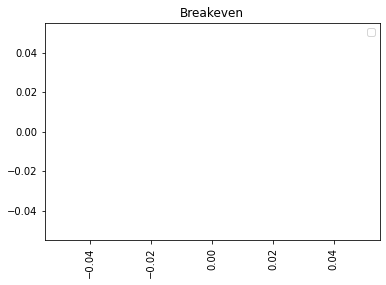

In [56]:
df = pd.read_csv('indicators/breakeven_clean.csv')
plt.scatter(df.city, df.breakeven_years)
plt.title('Breakeven')
plt.legend()
_ = plt.xticks(rotation=90)

#### Plotting indicators

In [57]:
# plot_indicators
# Plots a dataset containing indicators for a city
    # df             dataset to plot
    # indicators     list of indicators to plor (e.g. affordability income)
    # column_start   number of column to use for plotting, useful to limit the size of price series
    # nIndicators    number of indicators to plot
def plot_indicators(df, indicators, column_start, nIndicators):
    for i in range(len(indicators)):
        fig, ax = plt.subplots(figsize=(25, 15))
        plt.xticks(rotation=45)
        l = i*nIndicators
        m = i*nIndicators+1
        l = len(df)
        for j in range(len(df)):
            label = str(df.loc[j,'zipcode']) + "-" + str(df.loc[j,'city'])
            ax.plot(df.iloc[j,column_start:],'--', label=label)
        plt.title(indicators[i])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

### Affordability Income

Time series is quarterly based. If you want to plot a subset of the series, we can pass a `column start` relative to desired timeframe, e.g. to plot the last 21 years we can pass `84 (4 * 21 = 84)` to plot the first 21 years of the series or `-84` to plot the last 21 years of the series.

ValueError: could not convert string to float: 'New York, NY'

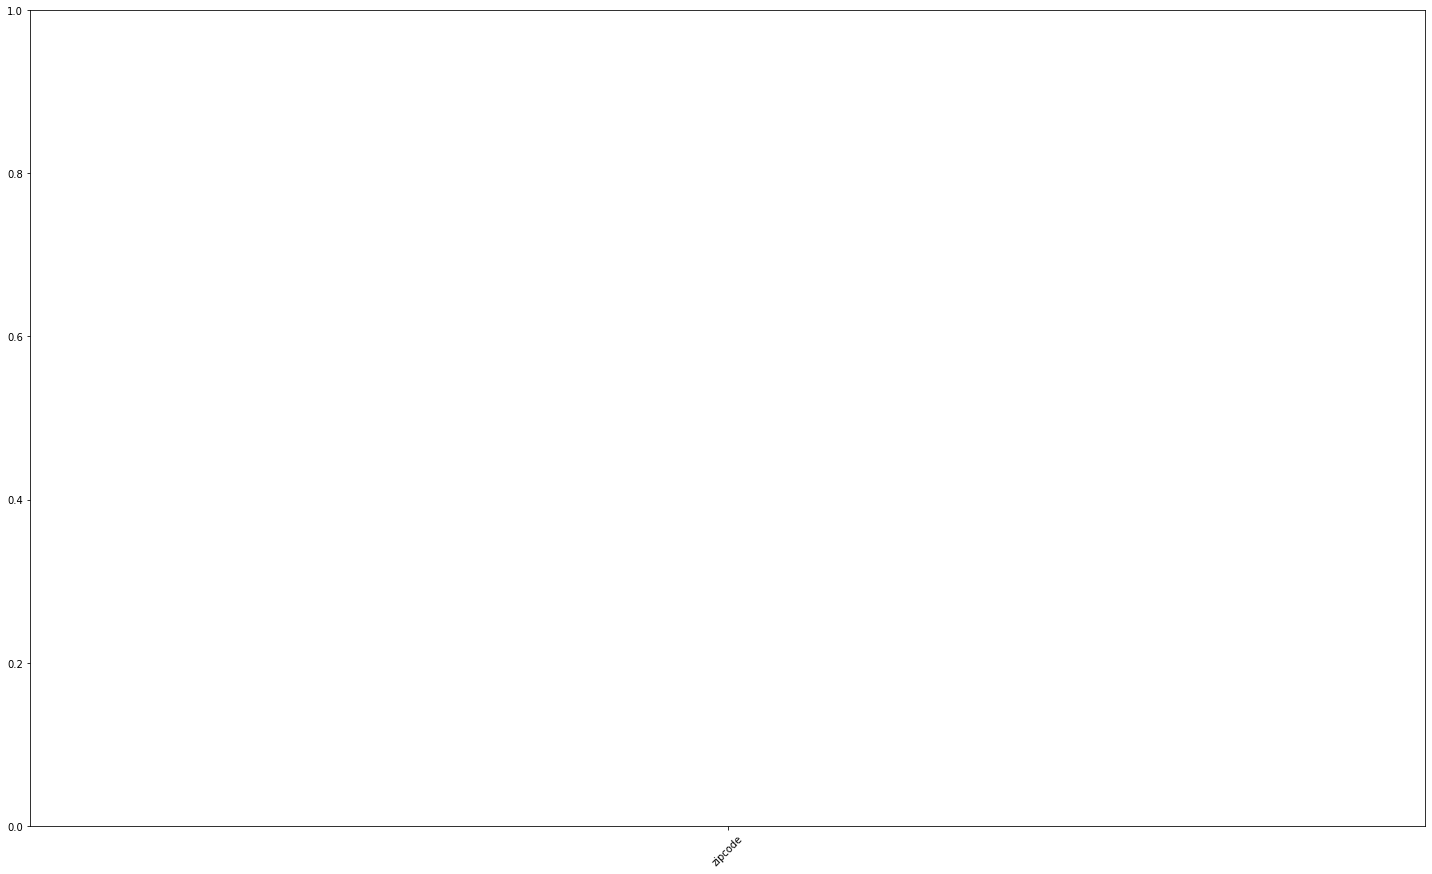

In [58]:
df = pd.read_csv('indicators/affordability_income.csv')
indicators = ['Income']
# time series for affordability_income starts at column 3
plot_indicators(df, indicators, -84, 1)

### Affordability Indicators

In [59]:
df = pd.read_csv('indicators/affordability_wide.csv')

In [60]:
# plot_affordability
# Plots the affordability dataset across all types of metrics of this indicator
    # df             dataset to plot
    # indicators     list of indicators to plor (e.g. affordability income)
    # column_start   number of column to use for plotting, useful to limit the size of price series
    # nIndicators    number of indicators to plot
def plot_affordability(df, indicators, column_start, nIndicators):
    for i in range(len(indicators)):
        dfi = df.query('Index == "' + indicators[i] + '"')
        dfi.reset_index(inplace=True)
        fig, ax = plt.subplots(figsize=(25, 15))
        plt.xticks(rotation=45)
        l = i*nIndicators
        m = i*nIndicators+1
        for j in range(len(dfi)):
            ax.plot(dfi.iloc[j,column_start:], '--', label=dfi.loc[j, 'city'])
        plt.title(indicators[i])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

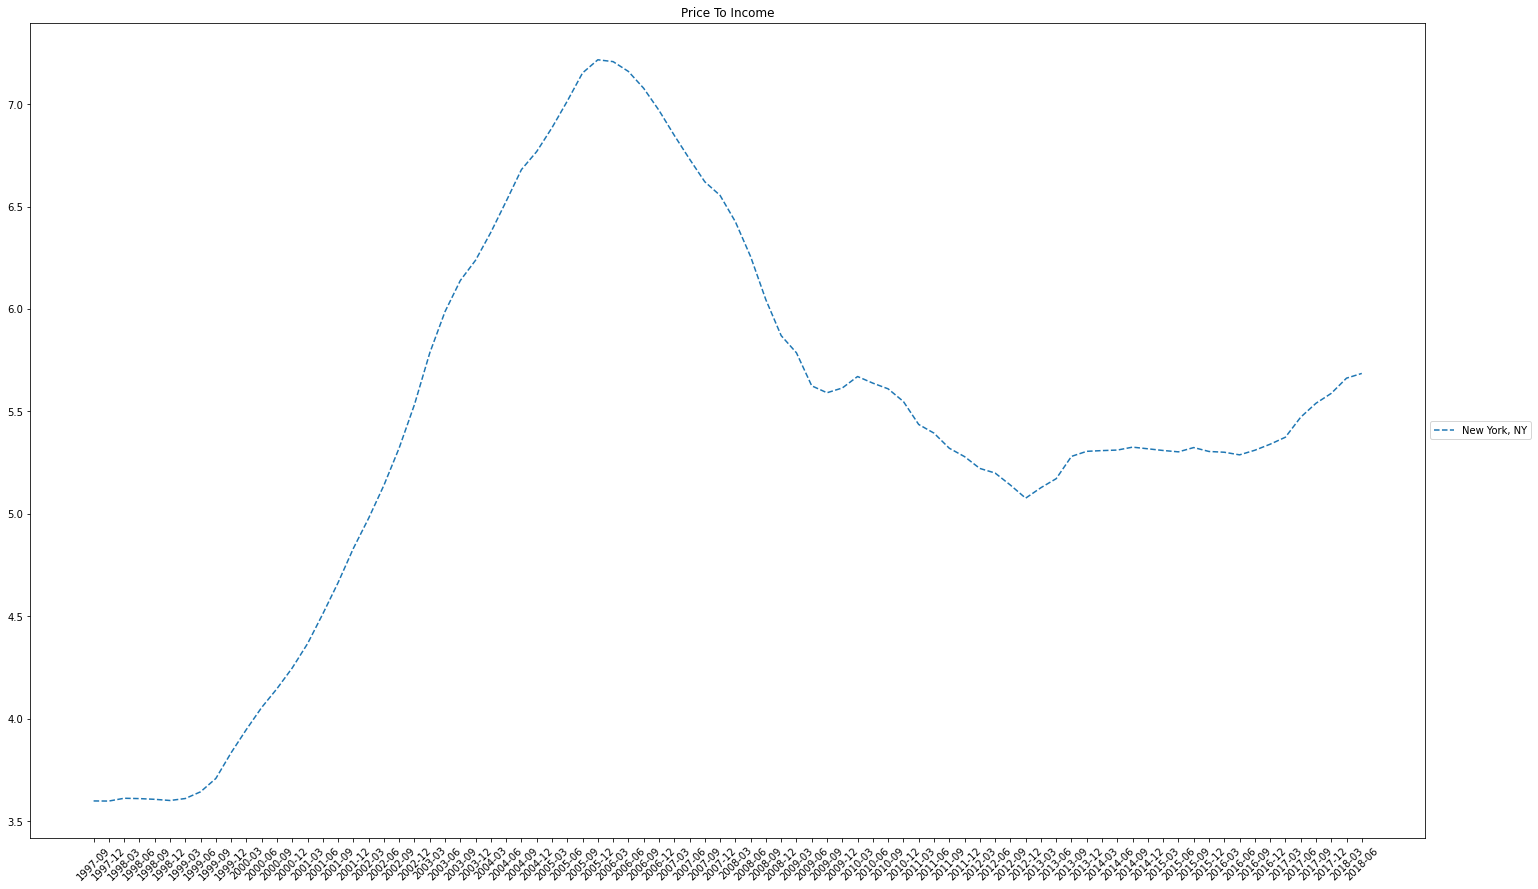

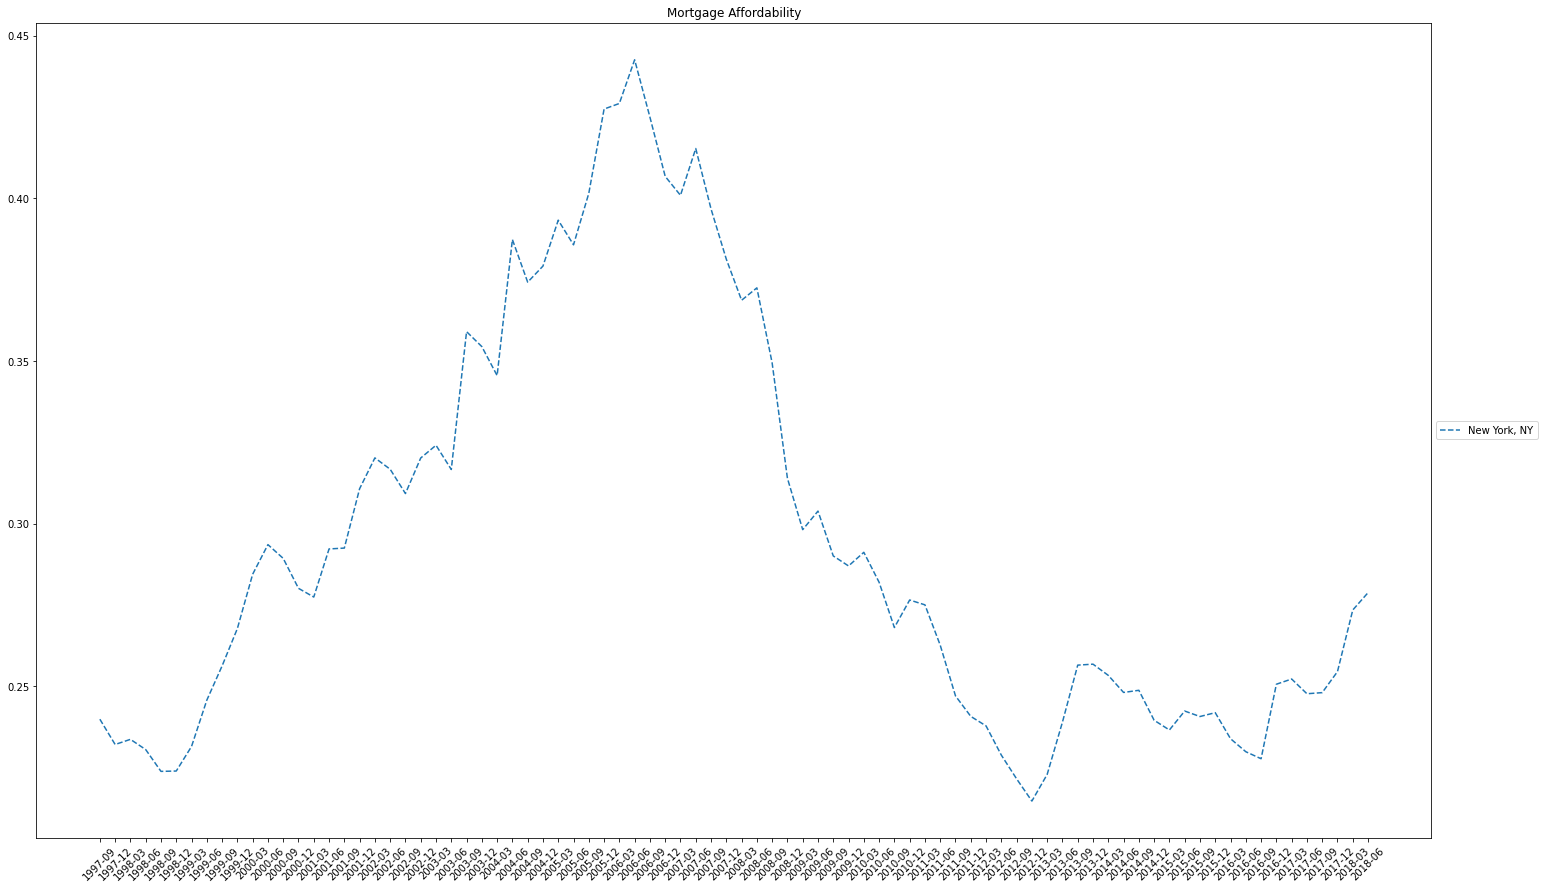

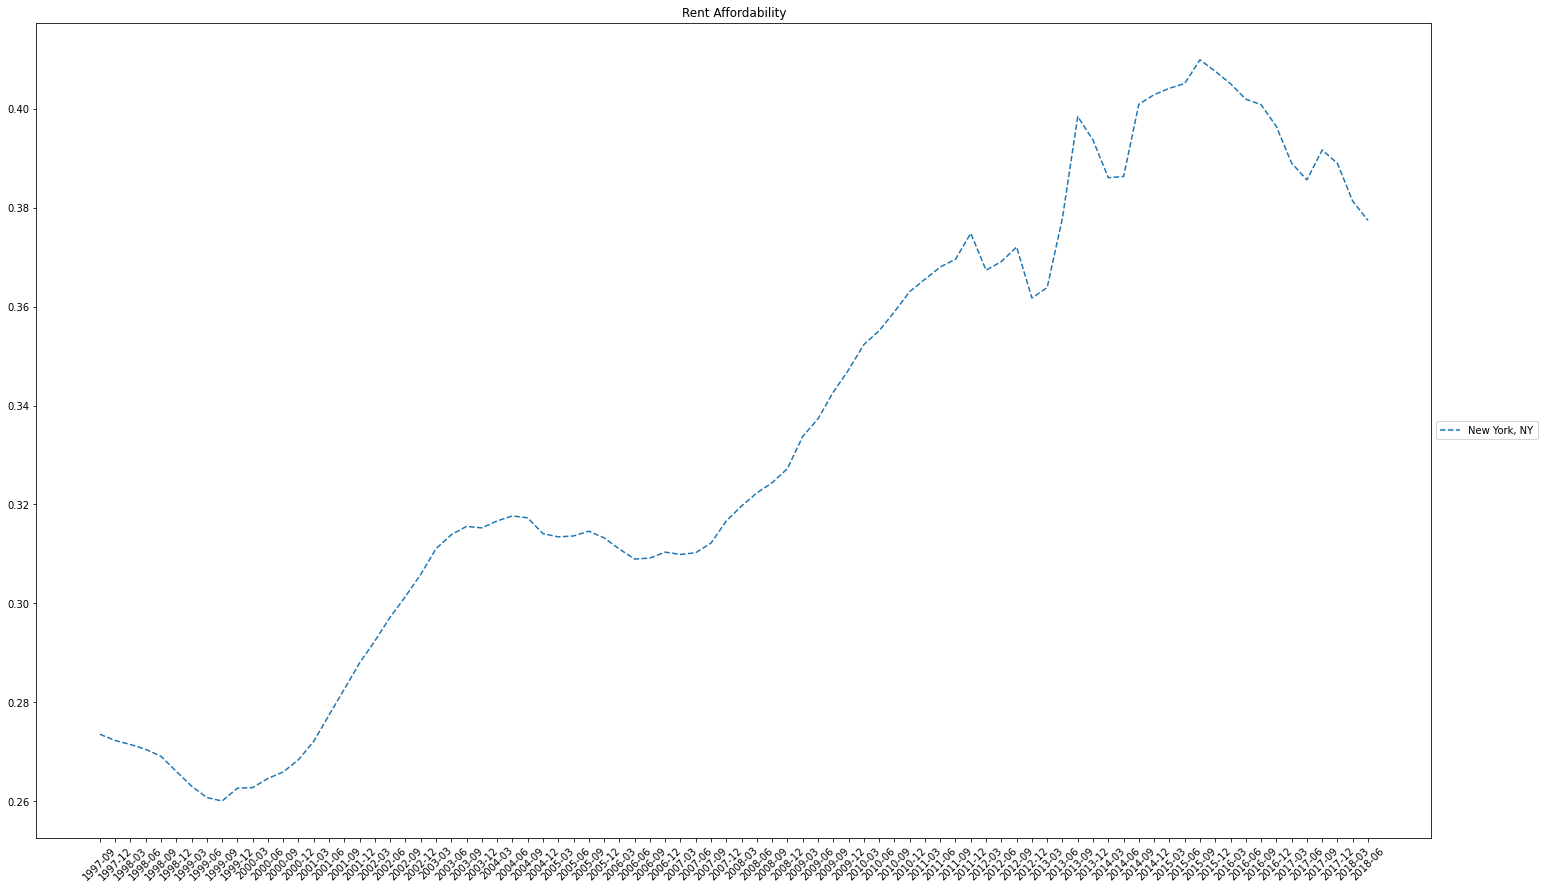

In [61]:
affordability_indicators = [
    'Price To Income',
    'Mortgage Affordability',
    'Rent Affordability'
]
# time series for affordability_wide starts at 6
plot_affordability(df, affordability_indicators, -84, 2)

### Home & Rent Forecast (YoY percentage change)

In [62]:
df = pd.read_csv('indicators/home_forecast.csv')
df = df[df.StateName.str.contains('|'.join(cstates), case=False, na=False)]
df = df.drop(['Region','MSAName','CountyName','CityName'],axis=1)
df = df.rename(index=str, columns={'ForecastYoYPctChange':'forecast_change'})
df

,Unnamed: 0,city,StateName,forecast_change


No handles with labels found to put in legend.


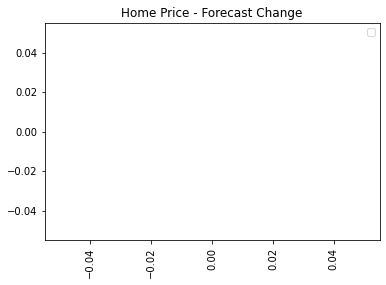

In [63]:
plt.scatter(df.city, df.forecast_change)
plt.title('Home Price - Forecast Change')
plt.legend()
_ = plt.xticks(rotation=90)

In [64]:
df = pd.read_csv('indicators/rent_forecast.csv')
df = df.drop(['RegionType','SizeRank','ZriForecast'],axis=1)
df = df.rename(index=str, columns={'Forecast_YoY_Change':'rent_forecast_change','Current_YoY_Change':'rent_current_change'})
df

,zipcode,city,rent_forecast_change,rent_current_change
0,394943,"Orlando, FL",0.027624,0.023322


No handles with labels found to put in legend.


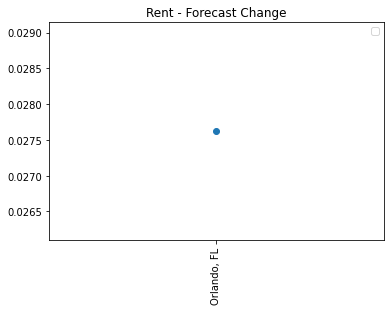

In [65]:
plt.scatter(df.city, df.rent_forecast_change)
plt.title('Rent - Forecast Change')
plt.legend()
_ = plt.xticks(rotation=90)

No handles with labels found to put in legend.


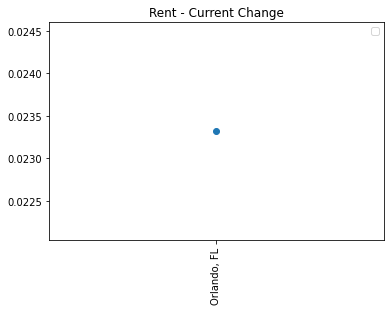

In [66]:
plt.scatter(df.city, df.rent_current_change)
plt.title('Rent - Current Change')
plt.legend()
_ = plt.xticks(rotation=90)

### Price Series

In [67]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

In [68]:
# plots the price series for a given combination of city, type of property
# column_start number of column to use for plotting, useful to limit the size of price series
# cities list of cities to plot
# types list of type of properties to plot (SF, 1BR, 2BR)
def plot_price_series(column_start, cities, types):
    for city in cities:
        for type in types:
            df = pd.read_csv(city + '/Zip_price_series_' + type + '.csv')
            fig, ax = plt.subplots(figsize=(25, 15))
            for i in range(len(df)):
                label = str(df.loc[i,'Zip']) + "-" + str(df.loc[i,'city'])
                ax.plot(df.iloc[i,column_start:],'--', label=label)
            plt.title(city + '- ' + type + ' Price Series')
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.xticks(np.arange(0,len(df.columns), step=len(df.columns)/12), np.arange(1996,2019,step=2), rotation=45)
            plt.show()

TypeError: 'value' must be an instance of str or bytes, not a numpy.float64

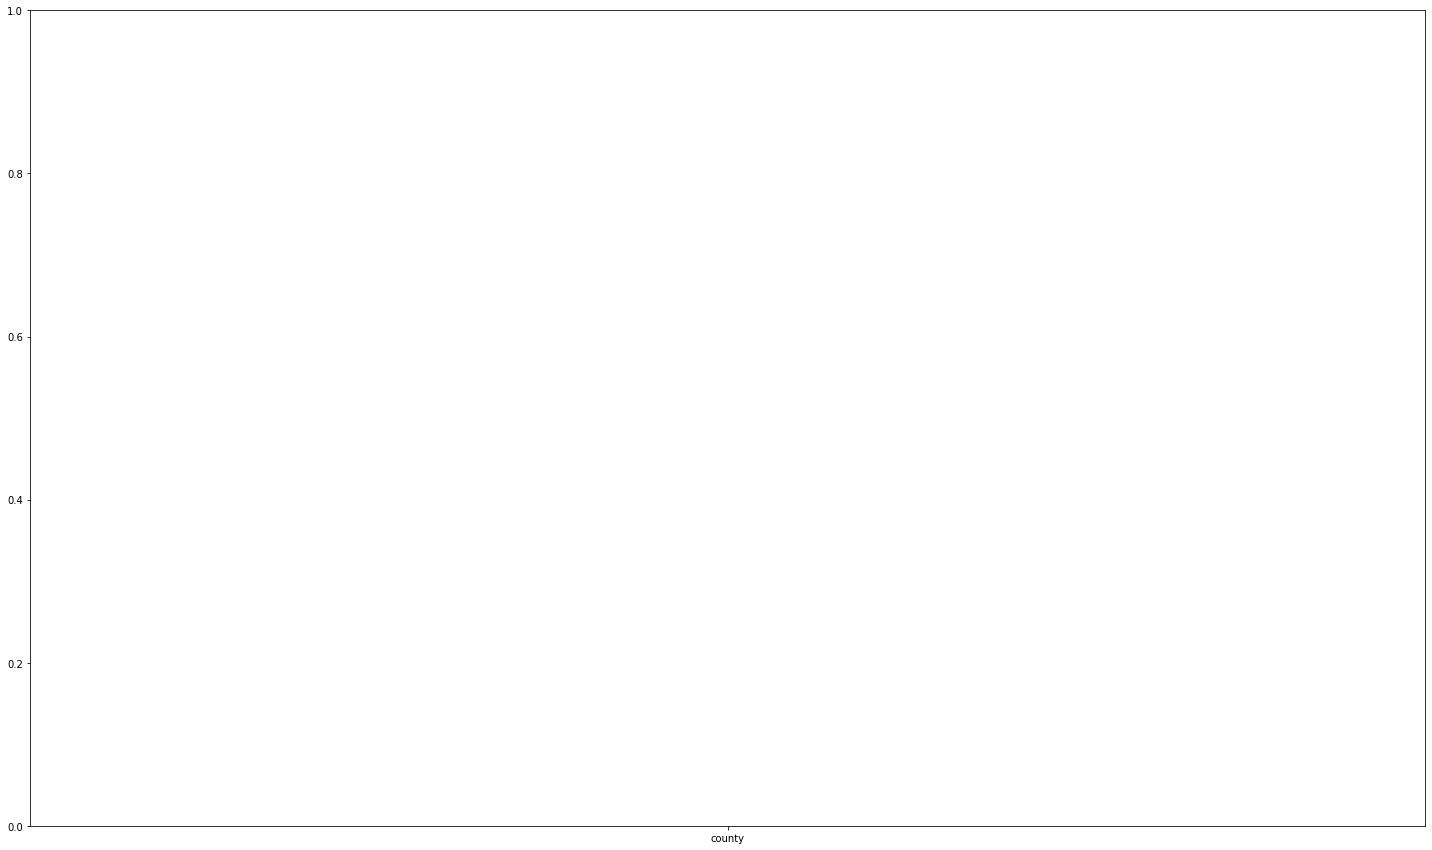

In [69]:
plot_price_series(7, ccities, ['SF'])

TypeError: 'value' must be an instance of str or bytes, not a numpy.float64

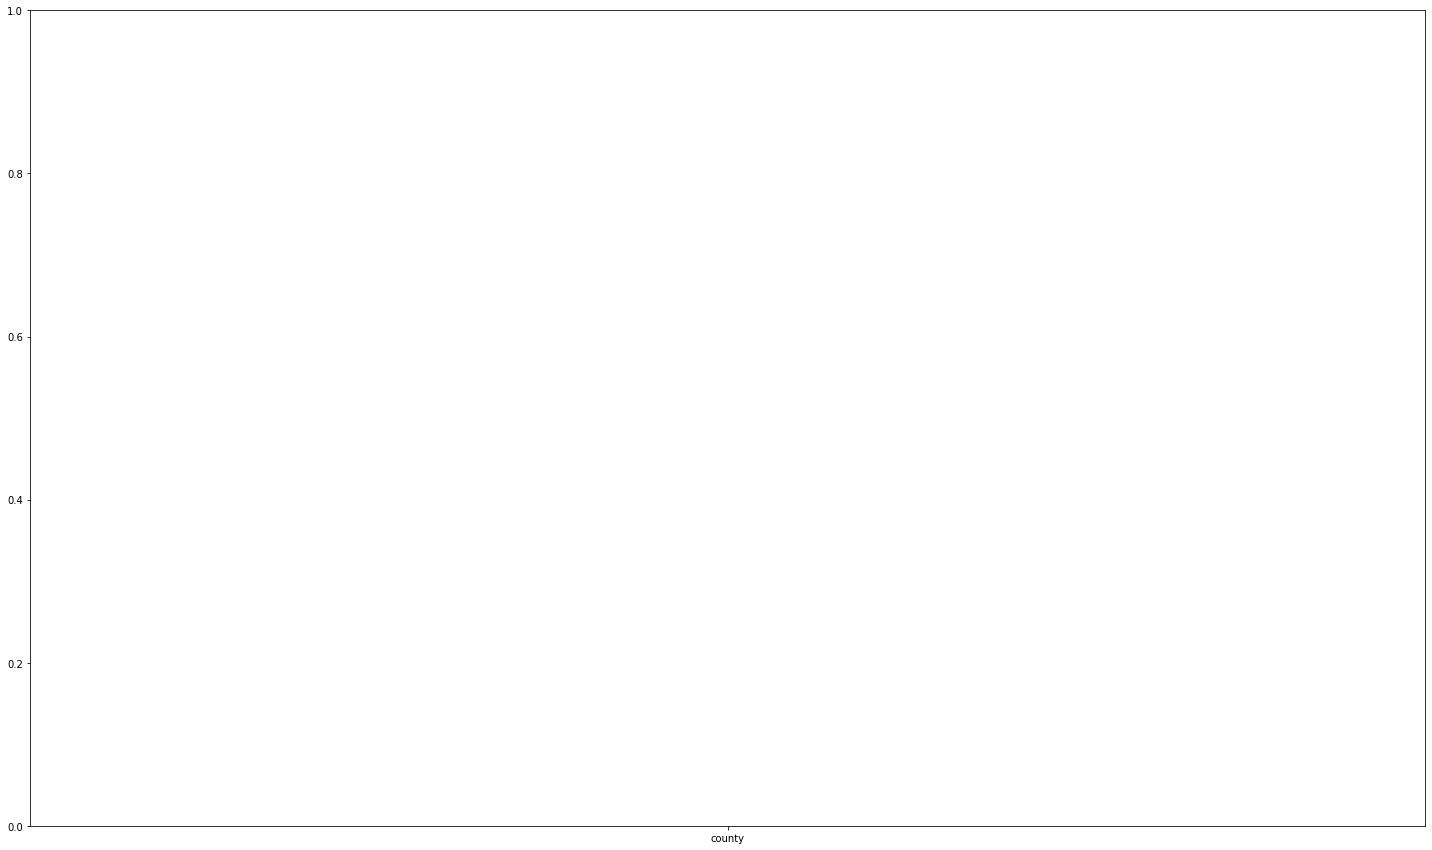

In [70]:
plot_price_series(7, ccities, ['1BR'])

In [ ]:
plot_price_series(7, ccities, ['2BR'])

## Consumer Price Index - Data Analysis

In [71]:
df = pd.read_csv('cpi/seattle.csv')

In [72]:
df['sea_index_dec_2017'] = df['sea_index_dec_2017'].astype(float)
df['item'] = df['item'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   item                57 non-null     category
 1   sea_index_dec_2017  57 non-null     float64 
 2   sea_index_feb_2018  57 non-null     float64 
 3   mia_index_dec_2017  57 non-null     float64 
 4   mia_index_feb_2018  57 non-null     float64 
dtypes: category(1), float64(4)
memory usage: 4.9 KB


In [73]:
df['diff_dec_2017'] = df['sea_index_dec_2017'] - df['mia_index_dec_2017']
df['diff_index_feb_2018'] = df['sea_index_feb_2018'] - df['mia_index_feb_2018']

In [74]:
df

,item,sea_index_dec_2017,sea_index_feb_2018,mia_index_dec_2017,mia_index_feb_2018,diff_dec_2017,diff_index_feb_2018
0,All items,265.85,268.03,258.24,264.99,7.61,3.04
1,All items (1967=100),810.41,817.06,416.24,427.13,394.17,389.93
2,Food and beverages,265.97,266.61,262.83,261.15,3.14,5.46
3,Food,268.57,269.19,264.86,263.62,3.71,5.57
4,Food at home,248.17,248.61,255.01,252.88,-6.84,-4.27
5,Cereals and bakery products,282.71,280.17,271.32,273.68,11.39,6.49
6,"Meats, poultry, fish, and eggs",207.65,203.23,247.80,237.27,-40.15,-34.04
7,Dairy and related products,217.02,219.33,219.60,221.07,-2.58,-1.74
8,Fruits and vegetables,402.99,400.63,338.32,347.16,64.67,53.47
9,Nonalcoholic beverages and beverage materials(1),279.25,298.94,252.06,247.35,27.19,51.59
